### Load Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

### Load in Test and Validation Data

y_test and y_val labels have to be converted to integer for roc computation
x_test and x_val needs to have certain columns dropped

In [2]:
## Load in Test Set
X_test_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/test/X_test_enc.parquet"
X_test = pd.read_parquet(X_test_path)

y_test_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/test/y_test.parquet"
y_test = pd.read_parquet(y_test_path)
y_test = pd.DataFrame(y_test['label'].astype(int)) ## convert labels to int for roc auc calculation

## Load in Validation Set
X_val_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/validation/X_val_enc.parquet"
X_val = pd.read_parquet(X_val_path)

y_val_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/validation/y_val.parquet"
y_val = pd.read_parquet(y_val_path)
y_val = pd.DataFrame(y_val['label'].astype(int))

y_train_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/training/y_train.parquet"
y_train = pd.read_parquet(y_train_path)
y_train = pd.DataFrame(y_train['label'].astype(int))

### Create Functions Needed For :

- Basic Classification
- Hyperparameter tuning using Randomized Search CV
- Feature Selection

link to understand RandomForestClassifier different parameters

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [3]:
## function for basic classification
def random_forest(x_train, y_train, x_val, y_val, x_test, y_test, variable):
    ## create classifier
    clf = RandomForestClassifier(random_state = 1)

    ## train the model
    clf.fit(x_train, y_train)

    ## get validation and test predicition
    y_val_pred = clf.predict(x_val)
    print('Accuracy of random forest classifier on validation set using {}: {:.2f}'.format(variable, metrics.accuracy_score(y_val, y_val_pred)))
   
    y_test_pred = clf.predict(x_test)
    print('Accuracy of random forest classifier on test set using {}: {:.2f}'.format(variable, metrics.accuracy_score(y_test, y_test_pred)))

    ## define metrics for roc
    y_test_pred_proba = clf.predict_proba(x_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    rf_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    
    ## create roc curve   
    plt.figure()
    plt.plot(fpr, tpr, label = 'Random Forest Classifier (area = %0.2f)' % rf_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc = "lower right")
    plt.show()

    ## define metric for precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba)
    auc_precision_recall = auc(recall, precision)

    ## create pr curve   
    plt.figure()
    plt.plot(recall, precision, label = 'Random Forest Classifier (area = %0.2f)' % auc_precision_recall)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall')
    plt.legend(loc = "lower right")
    plt.show()

In [16]:
## function for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

def params_tuning(param_grid, X_train, y_train):
    rf = RandomForestClassifier(random_state = 1)

    ## random search of parameters using 3 fold cross validation
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 50, cv = 3, random_state = 7, n_jobs = -1)
    rf_random.fit(X_train, y_train)

    return rf_random.best_params_

In [33]:
## function for feature selection
from sklearn.feature_selection import SelectFromModel

def var_selection(X_train, y_train, rf):
    sel = SelectFromModel(rf)
    sel.fit(X_train, y_train)

    return X_train.columns[(sel.get_support())]

# Modelling on 25th Quantile

In [4]:
## define columns to drop
cols_to_drop_25 = ['dwelling_time_-1_50', 'dwelling_time_-1_75', 'dwelling_time_-1_mean', 'std_-1_50', 'std_-1_75', 'std_-1_mean', 'mean_-1_50', 'mean_-1_75', 'mean_-1_mean',
                'dwelling_time_0_50', 'dwelling_time_0_75', 'dwelling_time_0_mean', 'std_0_50', 'std_0_75', 'std_0_mean', 'mean_0_50', 'mean_0_75', 'mean_0_mean',
                'dwelling_time_+1_50', 'dwelling_time_+1_75', 'dwelling_time_+1_mean', 'std_+1_50', 'std_+1_75', 'std_+1_mean', 'mean_+1_50', 'mean_+1_75', 'mean_+1_mean']

## dropping columns from X_validation set
X_val_25 = X_val.drop(columns = cols_to_drop_25, axis = 1)

## dropping columns from X_test set
X_test_25 = X_test.drop(columns = cols_to_drop_25, axis = 1)

## Load X_train_25
X_train_25_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/training/X_train_25.parquet" ## to edit file path
X_train_25 = pd.read_parquet(X_train_25_path)

In [ ]:
X_train_25

In [26]:
X_train_25.columns

Index(['reads_count', 'dwelling_time_-1_25', 'std_-1_25', 'mean_-1_25',
       'dwelling_time_0_25', 'std_0_25', 'mean_0_25', 'dwelling_time_+1_25',
       'std_+1_25', 'mean_+1_25', 'position_0_A', 'position_0_C',
       'position_0_G', 'position_0_T', 'position_1_A', 'position_1_C',
       'position_1_G', 'position_1_T', 'position_2_A', 'position_2_C',
       'position_2_G', 'position_2_T', 'position_3_A', 'position_3_C',
       'position_3_G', 'position_3_T', 'position_4_A', 'position_4_C',
       'position_4_G', 'position_4_T'],
      dtype='object')

In [5]:
## check if training data are the same len
print(f"Number of Rows for X_train_25 and y_train: {len(X_train_25)}, {len(y_train)}")

## check if validation data are the same len
print(f"Number of Rows for X_val_25 and y_val: {len(X_val_25)}, {len(y_val)}")

## check if test data are the same len
print(f"Number of Rows for X_test_25 and y_test: {len(X_test_25)}, {len(y_test)}")

Number of Rows for X_train_25 and y_train: 37955, 37955
Number of Rows for X_val_25 and y_val: 17434, 17434
Number of Rows for X_test_25 and y_test: 16275, 16275


## Fitting of Basic RF Classifier

<ipython-input-3-da1e5591e4a7>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Accuracy of random forest classifier on validation set using 25th quantile: 0.93
Accuracy of random forest classifier on test set using 25th quantile: 0.94


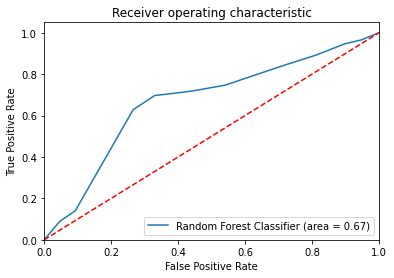

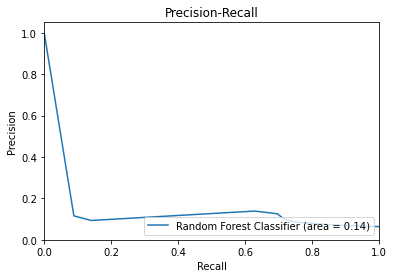

In [6]:
random_forest(X_train_25, y_train, X_val_25, y_val, X_test_25, y_test, "25th quantile")

## Loose Hyperparameter Tuning

In [23]:
## defining param_grid

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(100, 200, num = 11)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid_25 = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid_25)

{'n_estimators': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [24]:
best_param_25 = params_tuning(random_grid_25, X_train_25, y_train)
best_param_25

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

## Feature Selection

In [34]:
rf_fs_25 = RandomForestClassifier(random_state = 1, n_estimators = 200, min_samples_split = 2, 
                                min_samples_leaf = 1, max_features = 'sqrt', max_depth = None, bootstrap = False)
rf_fs_25.fit(X_train_25, y_train)

best_var_25 = var_selection(X_train_25, y_train, rf_fs_25)
print(best_var_25)

<ipython-input-34-675260417135>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fs_25.fit(X_train_25, y_train)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


Index(['reads_count', 'dwelling_time_-1_25', 'std_-1_25', 'mean_-1_25',
       'dwelling_time_0_25', 'std_0_25', 'mean_0_25', 'dwelling_time_+1_25',
       'std_+1_25', 'mean_+1_25'],
      dtype='object')


<ipython-input-3-da1e5591e4a7>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Accuracy of random forest classifier on validation set using 25th quantile: 0.93
Accuracy of random forest classifier on test set using 25th quantile: 0.94


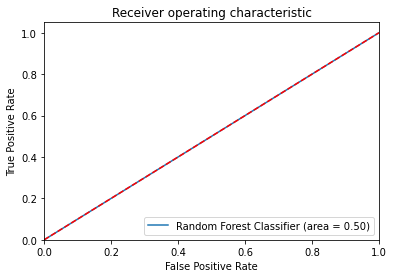

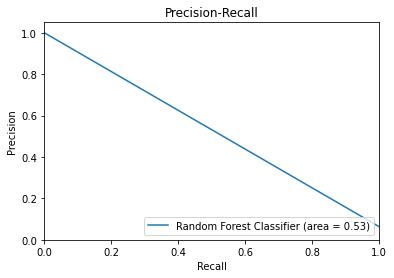

In [37]:
random_forest(X_train_25[list(best_var_25)], y_train, X_val_25[list(best_var_25)], y_val, X_test_25[list(best_var_25)], y_test, "25th quantile")

# Modelling on 50th Quantile

In [7]:
## define columns to drop
cols_to_drop_50 = ['dwelling_time_-1_25', 'dwelling_time_-1_75', 'dwelling_time_-1_mean', 'std_-1_25', 'std_-1_75', 'std_-1_mean', 'mean_-1_25', 'mean_-1_75', 'mean_-1_mean',
                'dwelling_time_0_25', 'dwelling_time_0_75', 'dwelling_time_0_mean', 'std_0_25', 'std_0_75', 'std_0_mean', 'mean_0_25', 'mean_0_75', 'mean_0_mean',
                'dwelling_time_+1_25', 'dwelling_time_+1_75', 'dwelling_time_+1_mean', 'std_+1_25', 'std_+1_75', 'std_+1_mean', 'mean_+1_25', 'mean_+1_75', 'mean_+1_mean']

## dropping columns from X_validation set
X_val_50 = X_val.drop(columns = cols_to_drop_50, axis = 1)

## dropping columns from X_test set
X_test_50 = X_test.drop(columns = cols_to_drop_50, axis = 1)

## Load X_train_50
X_train_50_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/training/X_train_50.parquet" ## to edit file path
X_train_50 = pd.read_parquet(X_train_50_path)

In [8]:
## check if training data are the same len
print(f"Number of Rows for X_train_50 and y_train: {len(X_train_50)}, {len(y_train)}")

## check if validation data are the same len
print(f"Number of Rows for X_val_50 and y_val: {len(X_val_50)}, {len(y_val)}")

## check if test data are the same len
print(f"Number of Rows for X_test_50 and y_test: {len(X_test_50)}, {len(y_test)}")

Number of Rows for X_train_50 and y_train: 37955, 37955
Number of Rows for X_val_50 and y_val: 17434, 17434
Number of Rows for X_test_50 and y_test: 16275, 16275


<ipython-input-3-da1e5591e4a7>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Accuracy of random forest classifier on validation set using 50th quantile: 0.78
Accuracy of random forest classifier on test set using 50th quantile: 0.78


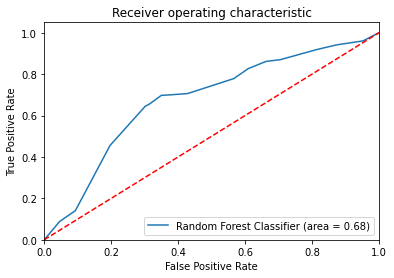

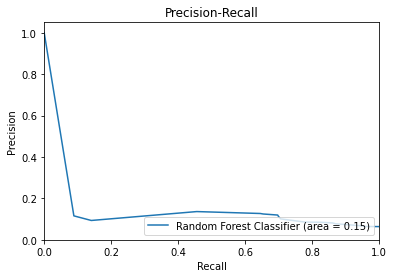

In [9]:
random_forest(X_train_50, y_train, X_val_50, y_val, X_test_50, y_test, "50th quantile")

# Modelling on 75th Quantile

In [10]:
## define columns to drop
cols_to_drop_75 = ['dwelling_time_-1_25', 'dwelling_time_-1_50', 'dwelling_time_-1_mean', 'std_-1_25', 'std_-1_50', 'std_-1_mean', 'mean_-1_25', 'mean_-1_50', 'mean_-1_mean',
                    'dwelling_time_0_25', 'dwelling_time_0_50', 'dwelling_time_0_mean', 'std_0_25', 'std_0_50', 'std_0_mean', 'mean_0_25', 'mean_0_50', 'mean_0_mean',
                    'dwelling_time_+1_25', 'dwelling_time_+1_50', 'dwelling_time_+1_mean', 'std_+1_25', 'std_+1_50', 'std_+1_mean', 'mean_+1_25', 'mean_+1_50', 'mean_+1_mean']

## dropping columns from X_validation set
X_val_75 = X_val.drop(columns = cols_to_drop_75, axis = 1)

## dropping columns from X_test set
X_test_75 = X_test.drop(columns = cols_to_drop_75, axis = 1)

## Load X_train_75
X_train_75_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/training/X_train_75.parquet" ## to edit file path
X_train_75 = pd.read_parquet(X_train_75_path)

In [11]:
## check if training data are the same len
print(f"Number of Rows for X_train_75 and y_train: {len(X_train_75)}, {len(y_train)}")

## check if validation data are the same len
print(f"Number of Rows for X_val_75 and y_val: {len(X_val_75)}, {len(y_val)}")

## check if test data are the same len
print(f"Number of Rows for X_test_75 and y_test: {len(X_test_75)}, {len(y_test)}")

Number of Rows for X_train_75 and y_train: 37955, 37955
Number of Rows for X_val_75 and y_val: 17434, 17434
Number of Rows for X_test_75 and y_test: 16275, 16275


<ipython-input-3-da1e5591e4a7>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Accuracy of random forest classifier on validation set using 75th quantile: 0.67
Accuracy of random forest classifier on test set using 75th quantile: 0.67


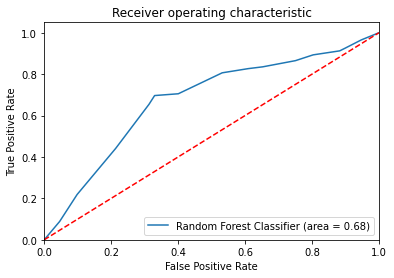

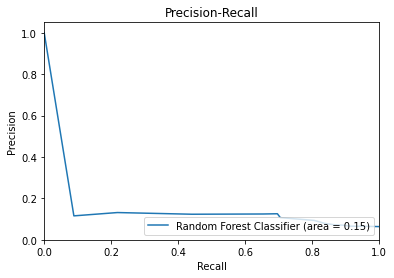

In [12]:
random_forest(X_train_75, y_train, X_val_75, y_val, X_test_75, y_test, "75th quantile")

# Modelling on Mean

In [13]:
## define columns to drop
cols_to_drop_mean = ['dwelling_time_-1_25', 'dwelling_time_-1_50', 'dwelling_time_-1_75', 'std_-1_25', 'std_-1_50', 'std_-1_75', 'mean_-1_25', 'mean_-1_50', 'mean_-1_75',
                    'dwelling_time_0_25', 'dwelling_time_0_50', 'dwelling_time_0_75', 'std_0_25', 'std_0_50', 'std_0_75', 'mean_0_25', 'mean_0_50', 'mean_0_75',
                    'dwelling_time_+1_25', 'dwelling_time_+1_50', 'dwelling_time_+1_75', 'std_+1_25', 'std_+1_50', 'std_+1_75', 'mean_+1_25', 'mean_+1_50', 'mean_+1_75']

## dropping columns from X_validation set
X_val_mean = X_val.drop(columns = cols_to_drop_mean, axis = 1)

## dropping columns from X_test set
X_test_mean = X_test.drop(columns = cols_to_drop_mean, axis = 1)

## Load X_train_mean
X_train_mean_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/training/X_train_mean.parquet" ## to edit file path
X_train_mean = pd.read_parquet(X_train_mean_path)

In [14]:
## check if training data are the same len
print(f"Number of Rows for X_train_mean and y_train: {len(X_train_mean)}, {len(y_train)}")

## check if validation data are the same len
print(f"Number of Rows for X_val_mean and y_val: {len(X_val_mean)}, {len(y_val)}")

## check if test data are the same len
print(f"Number of Rows for X_test_mean and y_test: {len(X_test_mean)}, {len(y_test)}")

Number of Rows for X_train_mean and y_train: 37955, 37955
Number of Rows for X_val_mean and y_val: 17434, 17434
Number of Rows for X_test_mean and y_test: 16275, 16275


<ipython-input-3-da1e5591e4a7>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Accuracy of random forest classifier on validation set using mean: 0.89
Accuracy of random forest classifier on test set using mean: 0.90


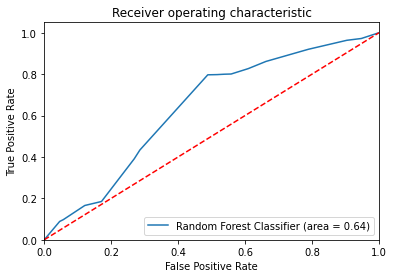

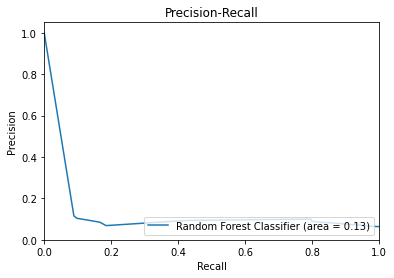

In [15]:
random_forest(X_train_mean, y_train, X_val_mean, y_val, X_test_mean, y_test, "mean")